In [16]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 1000, 'display.max_rows',1000)

# Read Data

In [17]:
def read_data_header(filename,read_lines=3):
    # Stocks Data is in UTC

    #generate header from the file
    with open(filename) as myfile:
        head1 =[]
        for i in range (0,read_lines):
            head1.append([str.split(next(myfile).strip(),sep=',') for x in range(0,1)])

    line1 = head1[0][0]
    line2 = head1[1][0]

    header = [i.replace('^','')+' '+j for i, j in zip(line1, line2)]
    header = [item.replace('var','variance') for item in header]

    return header

In [18]:
filename='data/news_tweets_sentiments.csv'
header = read_data_header(filename,2)
df= pd.read_csv(filename, sep=',',skiprows=2,names=header)
df.head(20)

,Date,combined count,combined mean,combined variance,negative count,negative mean,negative variance,neutral count,neutral mean,neutral variance,positive count,positive mean,positive variance,CL=FDirection mean,GSPCDirection mean,GSPTSEDirection mean,IXICDirection mean,BTC-USDDirection mean,TSLADirection mean
0,2022-01-26 09:30:00,35,-0.086669,0.190469,35,0.097171,0.009844,35,0.826114,0.016425,35,0.076771,0.007617,0.0,NaN,NaN,NaN,2.0,NaN
1,2022-01-26 09:45:00,1,0.340000,NaN,1,0.000000,NaN,1,0.833000,NaN,1,0.167000,NaN,2.0,0.0,0.0,0.0,0.0,0.0
2,2022-01-26 10:00:00,1,-0.812600,NaN,1,0.346000,NaN,1,0.654000,NaN,1,0.000000,NaN,2.0,2.0,2.0,2.0,2.0,2.0
3,2022-01-26 10:30:00,1,0.025800,NaN,1,0.092000,NaN,1,0.813000,NaN,1,0.095000,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-26 11:00:00,1,-0.440400,NaN,1,0.225000,NaN,1,0.775000,NaN,1,0.000000,NaN,2.0,2.0,2.0,2.0,0.0,2.0
5,2022-01-26 11:30:00,1,-0.444900,NaN,1,0.173000,NaN,1,0.827000,NaN,1,0.000000,NaN,2.0,2.0,2.0,2.0,2.0,2.0
6,2022-01-26 12:00:00,1,0.886000,NaN,1,0.000000,NaN,1,0.612000,NaN,1,0.388000,NaN,2.0,0.0,0.0,0.0,2.0,0.0
7,2022-01-26 12:30:00,1,0.855500,NaN,1,0.000000,NaN,1,0.561000,NaN,1,0.439000,NaN,2.0,2.0,2.0,2.0,0.0,2.0
8,2022-01-26 13:00:00,1,0.790600,NaN,1,0.000000,NaN,1,0.650000,NaN,1,0.350000,NaN,0.0,0.0,2.0,0.0,0.0,2.0
9,2022-01-26 13:15:00,1,0.765000,NaN,1,0.000000,NaN,1,0.798000,NaN,1,0.202000,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
TARGET = ["BTC-USDDirection mean"]
columns_predictors = ['combined mean']
#columns_predictors = ['negative mean','neutral mean','positive mean']
df = df[columns_predictors+TARGET].dropna(how='any')
X = df[columns_predictors]
y = df[TARGET]

<AxesSubplot:ylabel='Count'>

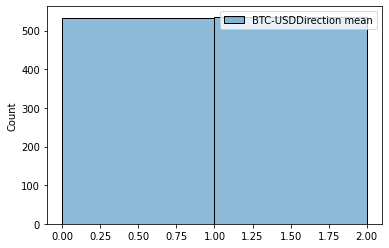

In [20]:
# check for balance data
# labels are balanced i.e equal split of inc and dec.
import seaborn as sns
sns.histplot(data=y, bins=2)

array([[<AxesSubplot:title={'center':'combined mean'}>]], dtype=object)

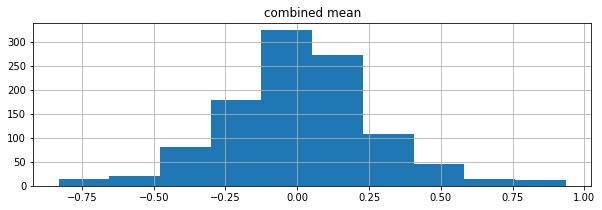

In [21]:
import matplotlib.pyplot as plt
X.hist(figsize=(10,3))

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10086)
print(f"X_train.shape: {X_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (801, 1)
X_test.shape: (268, 1)
y_train.shape: (801, 1)
y_test.shape: (268, 1)


In [23]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

def classification_metric(y_test,y_pred):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred) 
    print("%.2f" % accuracy)
    # Confusion Matrix
    c_matrix= confusion_matrix(y_test,y_pred)
    print(c_matrix)
    return None

def model_evaluation(model,X_train,y_train,X_test,y_test):
    model = model.fit(X_train,y_train)
    # training accuracy
    classification_metric(y_train,model.predict(X_train))

    #testing accuracy
    classification_metric(y_test,model.predict(X_test))
    return None

# SVM Model (Linear Model)

In [24]:
## Linear Features
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC

svm_clf = SVC(kernel="linear", C=100)
model_evaluation(svm_clf, X_train,y_train, X_test, y_test)

0.51
[[410   0]
 [391   0]]
0.46
[[123   0]
 [145   0]]


/Users/sarthakkaushik/Projects/uot/MachineLearning/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
## Polynomial Features Degree 2
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("svm_clf", LinearSVC(C=1, loss="hinge", random_state=42))
    ])
model_evaluation(polynomial_svm_clf, X_train,y_train, X_test, y_test)

0.51
[[410   0]
 [391   0]]
0.46
[[123   0]
 [145   0]]


/Users/sarthakkaushik/Projects/uot/MachineLearning/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("svm_clf", LinearSVC(C=1, loss="hinge", random_state=42))
    ])
model_evaluation(polynomial_svm_clf, X_train,y_train, X_test, y_test)

0.51
[[410   0]
 [391   0]]
0.46
[[123   0]
 [145   0]]


/Users/sarthakkaushik/Projects/uot/MachineLearning/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# SVM Model (Non_linear Model)

In [27]:
poly_kernel_svm_clf = Pipeline([
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=0.2, C=10))
    ])
model_evaluation(poly_kernel_svm_clf, X_train,y_train, X_test, y_test)


0.51
[[410   0]
 [391   0]]
0.46
[[123   0]
 [145   0]]


/Users/sarthakkaushik/Projects/uot/MachineLearning/env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
